In [64]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
from statsmodels.tsa.stattools import pacf, acf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

matplotlib.rcParams['figure.figsize'] = [16, 4]
pd.set_option('display.max_columns', 100)



In [4]:
df = pd.read_csv('dfTimeSeries_Example1.csv')

In [5]:
df.head(3)

,dept_id,state_id,cat_id,d,date,event_name_1,event_type_1,value_sales,sell_price
0,FOODS_1,CA,FOODS,d_1,2011-01-29,NaN,NaN,297,2.989109
1,FOODS_1,CA,FOODS,d_10,2011-02-07,NaN,NaN,176,3.016636
2,FOODS_1,CA,FOODS,d_100,2011-05-08,Mother's day,Cultural,211,2.987851


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13391 entries, 0 to 13390
Data columns (total 9 columns):
dept_id         13391 non-null object
state_id        13391 non-null object
cat_id          13391 non-null object
d               13391 non-null object
date            13391 non-null object
event_name_1    1078 non-null object
event_type_1    1078 non-null object
value_sales     13391 non-null int64
sell_price      13391 non-null float64
dtypes: float64(1), int64(1), object(7)
memory usage: 941.7+ KB


In [7]:
df['date'] = pd.to_datetime(df.date)
df = df[df['date'] >= '2014-01-01']

In [8]:
print(df.dept_id.unique())
lista_itens = df.dept_id.unique()

df_item1 = df.loc[df['dept_id'] == 'HOBBIES_1', : ]
df_item1.index = df_item1.date
df_item2 = df.loc[df['dept_id'] == 'HOUSEHOLD_1', : ]
df_item2.index = df_item2.date

['FOODS_1' 'FOODS_2' 'FOODS_3' 'HOBBIES_1' 'HOBBIES_2' 'HOUSEHOLD_1'
 'HOUSEHOLD_2']


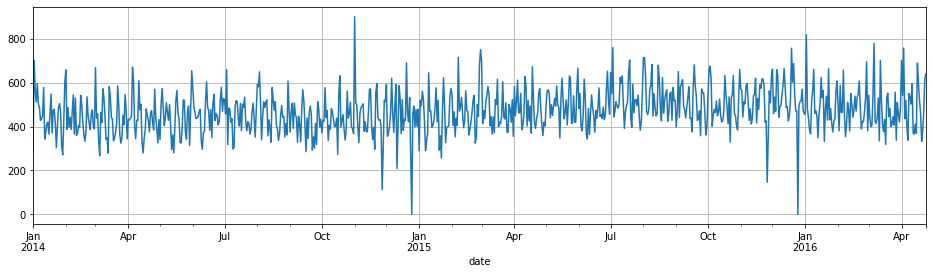

In [63]:
df_item1['value_sales'].plot(grid = True)

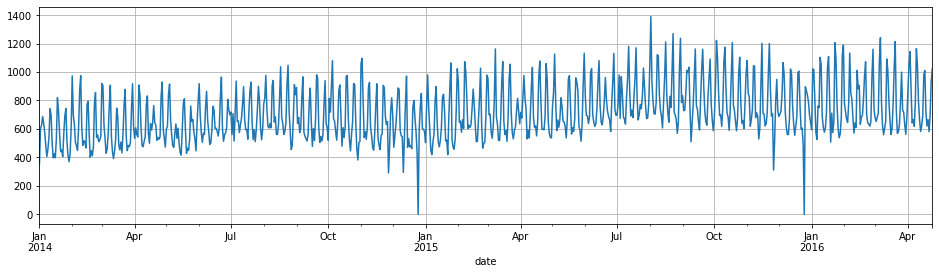

In [62]:
df_item2['value_sales'].plot(grid = True)

# 1º Conceito - Correlação entre duas séries

Por vezes, é bem comum que duas séries variem conjuntamente. Ou seja, quando uma tem um incremento, a outra sobe também. Nesse caso, o mesmo acontece quando uma das duas séries tem queda.

Correlação de vendas entre as duas séries:  67.0 %


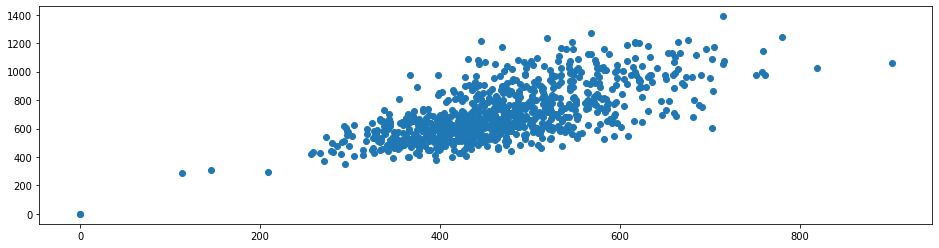

In [61]:
correlacao = df_item1['value_sales'].corr(df_item2['value_sales'])
print("Correlação de vendas entre as duas séries: ", np.round(correlacao*100), "%" ) 
plt.scatter(df_item1['value_sales'], df_item2['value_sales'])
plt.show()


$\rho  = 1 $ Correlação Totalmente Positiva

$\rho  = -1 $ Correlação Totalmente Negativa

$\rho = 0 $ Sem Correlação




Nem toda correlação entre duas séries significa necessariamente que elas são correlatas... https://www.tylervigen.com/spurious-correlations

Por isso, ao ver correlação entre duas séries, não devemos ver apenas os níveis, mas sim os retornos

In [14]:
diffs_dfitem1 = df_item1.loc[:,['value_sales']].diff().dropna()
diffs_dfitem1 = diffs_dfitem1[diffs_dfitem1['value_sales'] < float('inf') ]
diffs_dfitem2 = df_item2.loc[:,['value_sales']].diff().dropna()
diffs_dfitem2 = diffs_dfitem2[diffs_dfitem2['value_sales'] < float('inf') ]

In [15]:
correlacao = diffs_dfitem1['value_sales'].corr(diffs_dfitem2['value_sales'])
print("Correlação de vendas entre as diferenças das duas séries: ", np.round(correlacao*100), "%" ) 


Correlação de vendas entre as diferenças das duas séries:  53.0 %


# 2º Conceito - Autocorrelação

A autocorrelação de uma série, nada mais é do que a correlação de uma série temporal com uma cópia 'atrasada' de si mesma.

In [17]:
df_item1.loc[:,'lag1_sales'] = df_item1.value_sales.shift(1)
df_item1.loc[:,['dept_id','value_sales','lag1_sales']].head(5)

,dept_id,value_sales,lag1_sales
date,,,
2014-01-01,HOBBIES_1,294,NaN
2014-01-02,HOBBIES_1,702,294.0
2014-01-03,HOBBIES_1,565,702.0
2014-01-04,HOBBIES_1,513,565.0
2014-01-05,HOBBIES_1,597,513.0


In [18]:
autocorrelation = df_item2['value_sales'].autocorr()
print("A autocorrelação das vendas diárias com lag 1 é de " + str(np.round(autocorrelation*100)) + "%" )

A autocorrelação das vendas diárias com lag 1 é de 54.0%


Em ações, muitas estratégias de fundos multimercado são baseadas em autocorrelação dos retornos

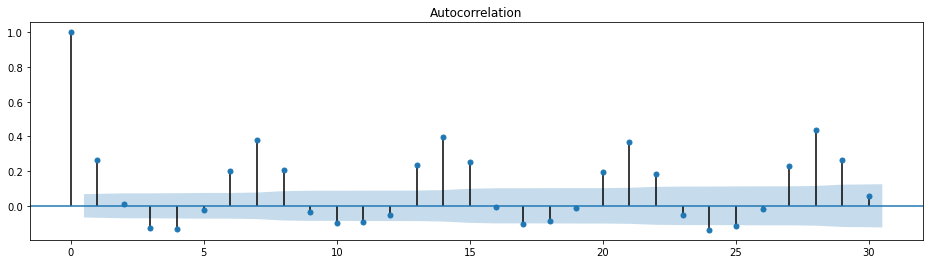

In [143]:
plot_acf(df_item1['value_sales'], alpha = 0.05);

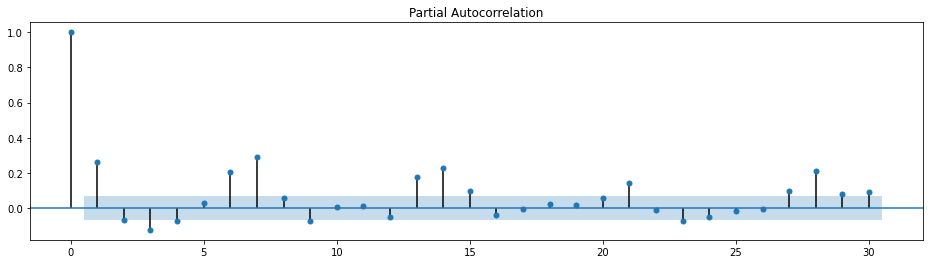

In [142]:
plot_pacf(df_item1['value_sales'], alpha = 0.05);

In [ ]:
#df.resample(rule = 'W').last()

 Muitas vezes, em séries temporais, variações diárias são improváveis de dizer o que irá acontecer amanhã, mas um movimento mais agregado no nível semana ou mês pode lhe dar uma pista sobre para onde está caminhando.

# 3º Conceito - Séries imprevisiveis (Rúido-branco e Random-Walk)


A definição de Ruído branco, é dada por 
* Média Constante através do Tempo
* Desvio Constante através do tempo
* 0 autocorrelação

#### Lembrar: Não ter autocorrelação não significa não ser previsivel, precisa ter os 3 conceitos alinhados

<Figure size 1152x288 with 0 Axes>

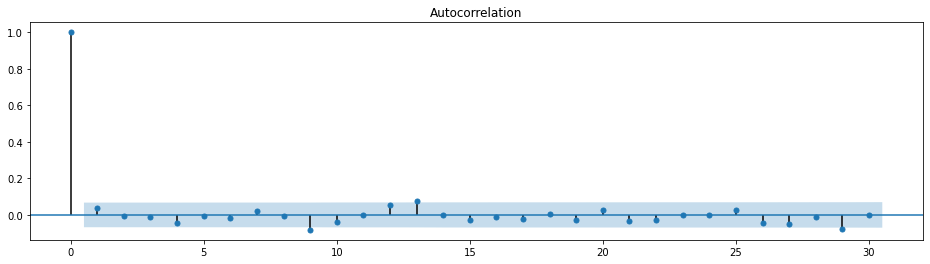

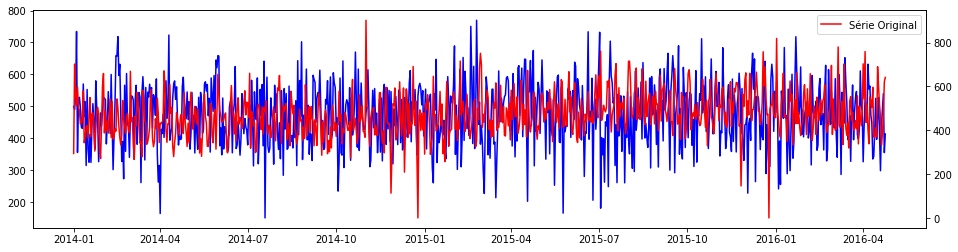

In [58]:
mean_item1 = df_item1['value_sales'].mean()
std_item1 = df_item1['value_sales'].std()
ruido = np.random.normal(mean_item1, std_item1, df_item1.shape[0])
plt.clf()
plot_acf(ruido)

#As duas séries no gráfico - Ruido e Série original
fig, ax = plt.subplots()
ax.plot(df_item1.index, ruido, color='blue')
ax2 = ax.twinx()
ax2.plot(df_item1.index, df_item1["value_sales"], color='red',label='Série Original')
plt.legend()
plt.show()

# 4º Conceito - Estacionariedade 

Em termos práticos, uma série estacionária é definida como aquela sem tendencia e sem sazonalidade.
Em termos formais, uma série estacionaria tem a distribuição invariada de acordo com o tempo. Ou seja, as propriedas estatísticas da série não mudam conforme o tempo.

Isso deve ser levado em consideração, pois, caso a série NÃO seja estacionária, teremos mais parametros para estimar.

Alguns parametros como sazonalidade podem ser mais facilmente controlados em ML, outros, como a tendência podem ser mais dificeis para o modelo entender

Para identificar estacionariedade, existem duas maneiras (complementares):
 *  Gráfico da Série
 *  Teste de Raíz unitária (teste de Dickey-Fuller aumentado)

#### Exemplos de Séries estácionárias (b, g) e não-estacionárias (demais): 
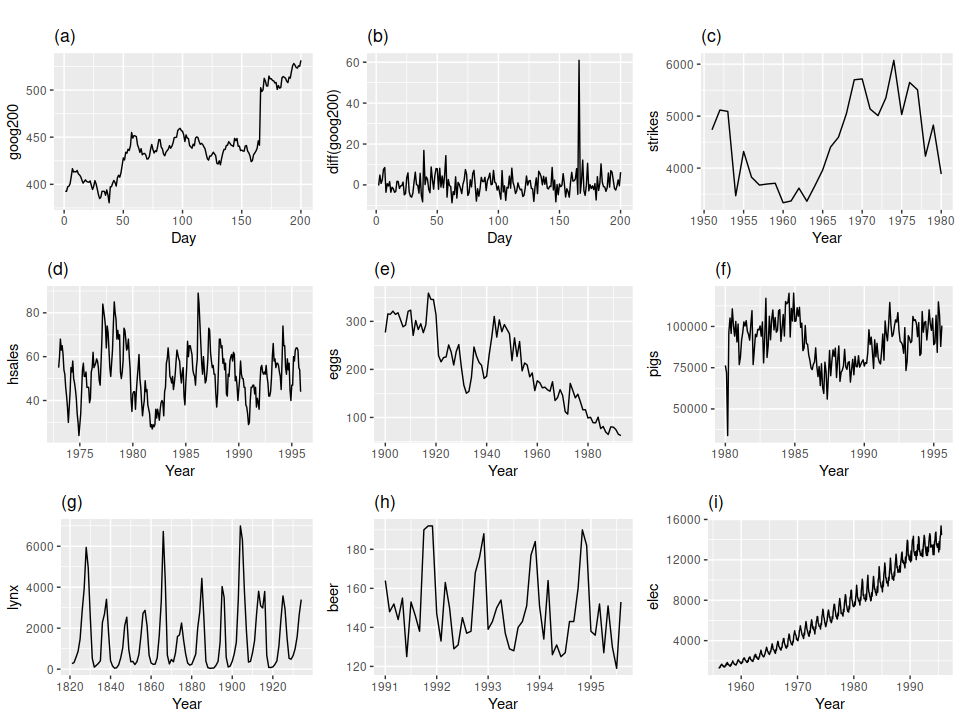
Fonte: Hyndman (2018) https://otexts.com/fpp2/stationarity.html

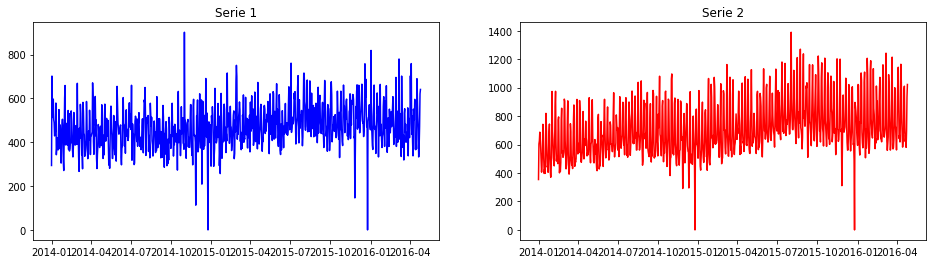

In [75]:
fig, ax = plt.subplots(1,2)
ax[0].plot(df_item1.index, df_item1.value_sales, color='blue')
ax[0].set_title('Serie 1')

ax[1].plot(df_item2.index, df_item2.value_sales, color='red')
ax[1].set_title('Serie 2')

plt.show()

In [89]:
adfuller_serie_1 = adfuller(df_item1.value_sales)
adfuller_serie_2 = adfuller(df_item2.value_sales)
print('p-valor do Teste aumentado de Dickey-Fuller para série 1: {0:.2f}%'.format(np.round(adfuller_serie_1[1],2))) 
print('p-valor do Teste aumentado de Dickey-Fuller para série 1: {0:.2f}%'.format(np.round(adfuller_serie_2[1],2)))

p-valor do Teste aumentado de Dickey-Fuller para série 1: 0.06%
p-valor do Teste aumentado de Dickey-Fuller para série 1: 0.26%


In [130]:
df_item1.loc[:,'diff_sales'] = df_item1.loc[:,'value_sales'].diff()
df_item2.loc[:,'diff_sales'] = df_item2.loc[:,'value_sales'].diff()

df_item1.head()

,dept_id,state_id,cat_id,d,date,event_name_1,event_type_1,value_sales,sell_price,lag1_sales,diff_sales
date,,,,,,,,,,,
2014-01-01,HOBBIES_1,CA,HOBBIES,d_1069,2014-01-01,NewYear,National,294,6.333581,NaN,NaN
2014-01-02,HOBBIES_1,CA,HOBBIES,d_1070,2014-01-02,NaN,NaN,702,6.333581,294.0,408.0
2014-01-03,HOBBIES_1,CA,HOBBIES,d_1071,2014-01-03,NaN,NaN,565,6.333581,702.0,-137.0
2014-01-04,HOBBIES_1,CA,HOBBIES,d_1072,2014-01-04,NaN,NaN,513,6.380265,565.0,-52.0
2014-01-05,HOBBIES_1,CA,HOBBIES,d_1073,2014-01-05,NaN,NaN,597,6.380265,513.0,84.0


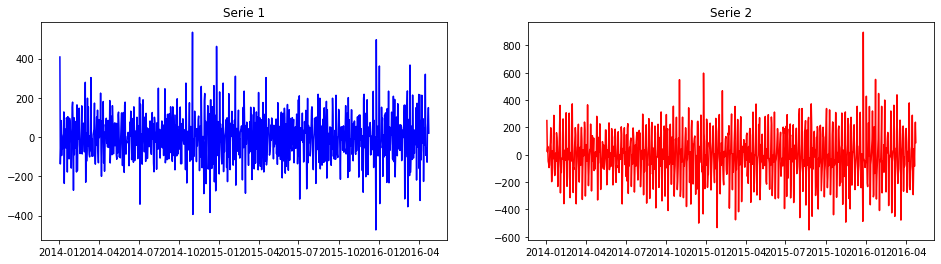

p-valor do Teste aumentado de Dickey-Fuller para série 1: 0.00%
p-valor do Teste aumentado de Dickey-Fuller para série 1: 0.00%


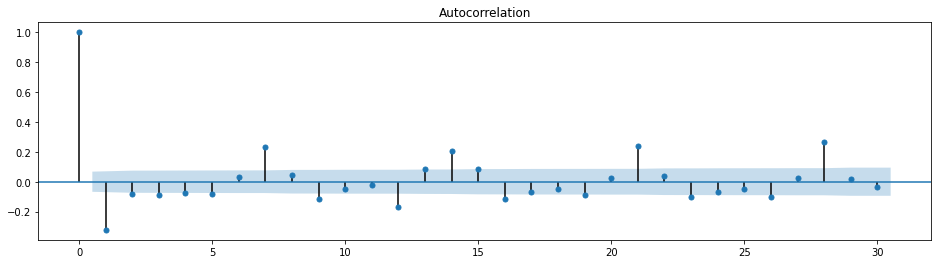

In [141]:
fig, ax = plt.subplots(1,2)
ax[0].plot(df_item1.index, df_item1.diff_sales, color='blue')
ax[0].set_title('Serie 1')

ax[1].plot(df_item2.index, df_item2.diff_sales, color='red')
ax[1].set_title('Serie 2')

plt.show()


adfuller_serie_1 = adfuller(df_item1.diff_sales.dropna())
adfuller_serie_2 = adfuller(df_item2.diff_sales.dropna())
print('p-valor do Teste aumentado de Dickey-Fuller para série 1: {0:.2f}%'.format(np.round(adfuller_serie_1[1],2))) 
print('p-valor do Teste aumentado de Dickey-Fuller para série 1: {0:.2f}%'.format(np.round(adfuller_serie_2[1],2))) 

plot_acf(df_item1.diff_sales.dropna(), alpha = 0.05);

# Um último ponto... Validação e Backtest

Métodos muito comuns para avaliar modelos, são o cross-validation ou o leave-one-out.

Porém, esses métodos, ignoram o conceito temporal do Time Series. Dessa forma, caso optemos pelo cross-validation por exemplo, em alguns momentos teremos dados do futuro prevendo o dado do passado.

#### Exemplo de Cross-Validation (NÃO deve ser usado em TS):
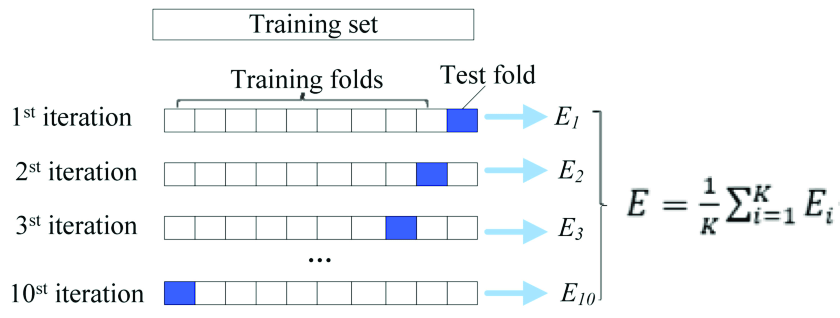
fonte: https://www.researchgate.net/figure/Ten-fold-cross-validation-diagram-The-dataset-was-divided-into-ten-parts-and-nine-of_fig1_326465007

Por isso, para treino e otimização da série temporal, devemos validar através de hold-out respeitando o conceito temporal.

#### Exemplo de validação Hold Out, respeitando o conceito temporal:

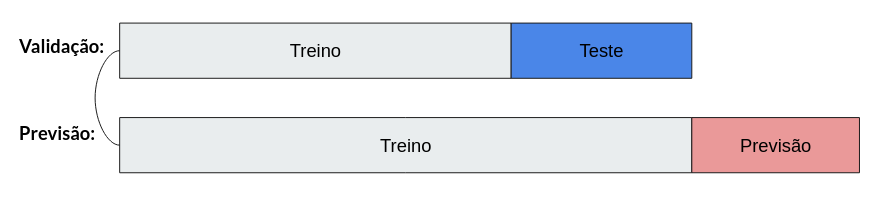

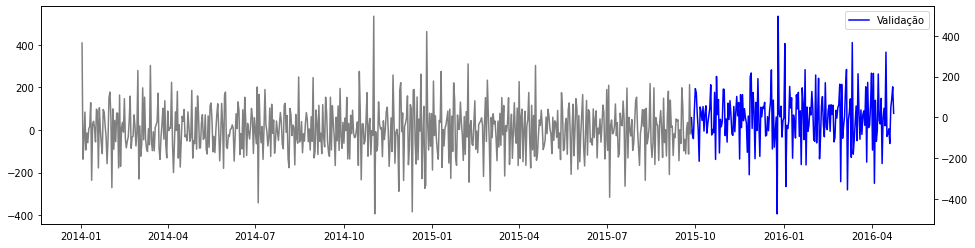

In [164]:
backtest_size = 0.75
train = df_item1.drop(['date'],axis=1).reset_index().loc[0:np.round(df_item1.shape[0]*backtest_size),:]
test = df_item1.drop(['date'],axis=1).reset_index().loc[np.round(df_item1.shape[0]*backtest_size):,:]

#from sklearn.model_selection import train_test_split

fig, ax = plt.subplots()
ax.plot(train.date, train.diff_sales, color='gray')
ax2 = ax.twinx()
ax2.plot(test.date, test.diff_sales, color='blue',label='Validação')
plt.legend()
plt.show()

# Enfim... Ajustando o modelo

Agora, iremos aplicar todos esses conceitos de série temporal, em um modelo de série temporal simples chamado *ARIMA* (autoregressive integrated moving average)

Porém, também podemos ajustar - respeitando os conceitos vistos de série temporal - em modelos regressores comuns, tais como:
* Árvores de Decisão (RandomForest, XGBoosting)
* Redes neurais simples (MLP)
* Regressões
* Support Vector Machine (SVM)

Ou até em modelos robustos que tem tal intuito, tal como o *Redes neurais com arquitetura LSTM (Long Short Term Memory)*, também utilizada para processamento de linguagem natural